云思木想2019秋装新款高领弹力前后打揽修身织带长袖T恤女36723


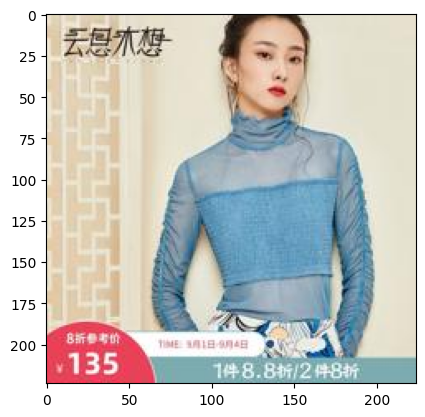

In [1]:
import pandas as pd 
from PIL import Image 
import matplotlib.pyplot as plt 
import os 


# 读取数据
df_train = pd.read_csv('../xfdata/train.csv', sep="\t")
df_test_text = pd.read_csv('../xfdata/test_query.csv')

for image_name in df_train['path'][: 1]:
    img_path = os.path.join('../xfdata/image', image_name)
    # 需要将图片左右翻转，这样才能调正
    text = df_train.loc[df_train['path']==image_name, 'title'].values[0]
    print(text)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

In [2]:
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import os
import torch 


device = "cuda" if torch.cuda.is_available() else "cpu"
# 设置镜像端点
os.environ["HF_ENDPOINT"] = "https://huggingface.co"
os.environ["TRANSFORMERS_CACHE"] = "hf-mirror"
model_path = "/root/onethingai-tmp/models--OFA-Sys--chinese-clip-vit-huge-patch14/snapshots/503e16b560aff94c1922f13a86a7693d36957a4f"
model = ChineseCLIPModel.from_pretrained(model_path).to(device)
processor = ChineseCLIPProcessor.from_pretrained(model_path)
print("Loading Done!")

2024-09-24 10:03:01.394801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 10:03:01.419475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 10:03:01.449196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 10:03:01.457433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 10:03:01.479629: I tensorflow/core/platform/cpu_feature_guar

Loading Done!


/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from peft import get_peft_model, LoraConfig
import torch 
import transformers


# 只微调qkv
target_modules = []
for i in range(24):
    target_modules.append(f"text_model.encoder.layer.{i}.attention.self.query")
    target_modules.append(f"text_model.encoder.layer.{i}.attention.self.key")
    target_modules.append(f"text_model.encoder.layer.{i}.attention.self.value")
    
for i in range(32):
    target_modules.append(f"vision_model.emcoder.layers.{i}.self_attn.q_proj")
    target_modules.append(f"vision_model.emcoder.layers.{i}.self_attn.k_proj")
    target_modules.append(f"vision_model.emcoder.layers.{i}.self_attn.v_proj")

# LoRA配置
lora_config = LoraConfig(
    r=64,
    lora_alpha=96,
    target_modules=target_modules
)

# 将 LoRA 应用于模型
lora_model = get_peft_model(model, lora_config)
print("LoRA Done!")

LoRA Done!


In [4]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import torch 
import numpy as np 

df_train = pd.read_csv('../xfdata/train.csv', sep="\t")
# df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
img_path = "../xfdata/image"
df_train["image_path"] = df_train["path"].apply(lambda x: os.path.join(img_path, x))
# df_valid["image_path"] = df_valid["path"].apply(lambda x: os.path.join(img_path, x))
# print(df_train.shape, df_valid.shape)
train_dataset = Dataset.from_pandas(df_train)
# valid_dataset = Dataset.from_pandas(df_valid)
train_dataset

Dataset({
    features: ['title', 'path', 'image_path'],
    num_rows: 5000
})

In [5]:
import torch
import torch.nn.functional as F
from transformers import get_cosine_schedule_with_warmup
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from peft import PeftModel
import logging

# 配置 logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        # logging.FileHandler("train_text_model.log"),
        logging.StreamHandler()
    ]
)


# 训练模型的自定义循环
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    progress_bar = tqdm(dataloader, desc="Training", leave=False, dynamic_ncols=True)
    
    for batch in progress_bar:
        # 将数据移动到GPU
        images = []
        for image_path in batch["image_path"]:
            try:
                images.append(Image.open(image_path).transpose(Image.FLIP_LEFT_RIGHT).convert("RGB"))
            except:
                images.append(Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8)).convert("RGB"))
        inputs = processor(text=batch["title"], images=images, return_tensors="pt", padding=True, truncation=True, max_length=52).to(device)
        outputs = model(**inputs, return_loss=True)
        logits_per_text = outputs["logits_per_text"]
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # 保存预测和标签
        preds = torch.argmax(logits_per_text, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(np.arange(logits_per_text.shape[0]))
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc

def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False, dynamic_ncols=True)
    
    with torch.no_grad():
        for batch in progress_bar:
            # 将数据移动到GPU
            images = []
            for image_path in batch["image_path"]:
                try:
                    images.append(Image.open(image_path).convert("RGB"))
                except:
                    images.append(Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8)).transpose(Image.FLIP_LEFT_RIGHT).convert("RGB"))
            inputs = processor(text=batch["title"], images=images, return_tensors="pt", padding=True, truncation=True, max_length=52).to(device)
            outputs = model(**inputs, return_loss=True)
            logits_per_text = outputs["logits_per_text"]
            loss = outputs.loss
            total_loss += loss.item()
            # 保存预测和标签
            preds = torch.argmax(logits_per_text, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(np.arange(logits_per_text.shape[0]))
            progress_bar.set_postfix(loss=loss.item())
    
        avg_loss = total_loss / len(dataloader)
        acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc

# 设置Epoch
num_epochs = 30
# 定义批量
batch_size = 625
# 定义dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
# 定义优化器
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=4e-5)
# 设置设备为GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)
logging.info(f"Epoch 0/{num_epochs}")
# valid_loss, valid_acc = evaluate_epoch(lora_model, train_dataloader, device)
# logging.info(f"Training Loss: {valid_loss}, Acc: {valid_acc}")
# valid_loss, valid_acc = evaluate_epoch(lora_model, valid_dataloader, device)
# logging.info(f"Validation Loss: {valid_loss}, Acc: {valid_acc}")

# 训练循环
for epoch in range(num_epochs):
    logging.info(f"Epoch {epoch + 1}/{num_epochs}")
    # 训练一个epoch
    train_loss, train_acc = train_epoch(lora_model, train_dataloader, optimizer, device)
    logging.info(f"Training Loss: {train_loss}, Acc: {train_acc}")
    # 在验证集上评估
    # valid_loss, valid_acc = evaluate_epoch(lora_model, valid_dataloader, device)
    # logging.info(f"Validation Loss: {valid_loss}, Acc: {valid_acc}")
    # lora_model.save_pretrained(f"./adapter/adapter_{epoch+1}")
torch.save(lora_model, '../user_data/LoRA.pth')

2024-09-24 10:03:05,203 [INFO] Epoch 0/30
2024-09-24 10:03:05,204 [INFO] Epoch 1/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:05:36,523 [INFO] Training Loss: 0.9535157158970833, Acc: 0.7416
2024-09-24 10:05:36,525 [INFO] Epoch 2/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:08:08,528 [INFO] Training Loss: 0.8857897743582726, Acc: 0.7552
2024-09-24 10:08:08,530 [INFO] Epoch 3/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:10:41,485 [INFO] Training Loss: 0.8397428542375565, Acc: 0.763
2024-09-24 10:10:41,486 [INFO] Epoch 4/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:13:13,903 [INFO] Training Loss: 0.7927541211247444, Acc: 0.7768
2024-09-24 10:13:13,904 [INFO] Epoch 5/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:15:46,166 [INFO] Training Loss: 0.7665343731641769, Acc: 0.7782
2024-09-24 10:15:46,168 [INFO] Epoch 6/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:18:18,749 [INFO] Training Loss: 0.7581663131713867, Acc: 0.7792
2024-09-24 10:18:18,751 [INFO] Epoch 7/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:20:51,097 [INFO] Training Loss: 0.7346543669700623, Acc: 0.7888
2024-09-24 10:20:51,099 [INFO] Epoch 8/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:23:23,737 [INFO] Training Loss: 0.7016604095697403, Acc: 0.791
2024-09-24 10:23:23,738 [INFO] Epoch 9/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:25:55,960 [INFO] Training Loss: 0.6918178126215935, Acc: 0.7906
2024-09-24 10:25:55,961 [INFO] Epoch 10/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:28:28,240 [INFO] Training Loss: 0.6802075207233429, Acc: 0.7998
2024-09-24 10:28:28,242 [INFO] Epoch 11/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:31:00,951 [INFO] Training Loss: 0.6596794277429581, Acc: 0.8056
2024-09-24 10:31:00,953 [INFO] Epoch 12/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:33:33,339 [INFO] Training Loss: 0.6454752683639526, Acc: 0.8082
2024-09-24 10:33:33,342 [INFO] Epoch 13/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:36:05,807 [INFO] Training Loss: 0.6284530088305473, Acc: 0.8058
2024-09-24 10:36:05,810 [INFO] Epoch 14/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:38:38,954 [INFO] Training Loss: 0.6098867133259773, Acc: 0.8092
2024-09-24 10:38:38,956 [INFO] Epoch 15/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:41:10,997 [INFO] Training Loss: 0.5944816097617149, Acc: 0.82
2024-09-24 10:41:10,999 [INFO] Epoch 16/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:43:43,724 [INFO] Training Loss: 0.5716699734330177, Acc: 0.8248
2024-09-24 10:43:43,726 [INFO] Epoch 17/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:46:16,589 [INFO] Training Loss: 0.5606864243745804, Acc: 0.823
2024-09-24 10:46:16,591 [INFO] Epoch 18/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:48:49,124 [INFO] Training Loss: 0.53885767608881, Acc: 0.8364
2024-09-24 10:48:49,125 [INFO] Epoch 19/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:51:21,477 [INFO] Training Loss: 0.5295067243278027, Acc: 0.8322
2024-09-24 10:51:21,479 [INFO] Epoch 20/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:53:54,274 [INFO] Training Loss: 0.5097652934491634, Acc: 0.8382
2024-09-24 10:53:54,276 [INFO] Epoch 21/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:56:26,500 [INFO] Training Loss: 0.5028155893087387, Acc: 0.833
2024-09-24 10:56:26,502 [INFO] Epoch 22/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 10:58:58,998 [INFO] Training Loss: 0.4843696802854538, Acc: 0.8464
2024-09-24 10:58:59,000 [INFO] Epoch 23/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:01:31,053 [INFO] Training Loss: 0.4686826430261135, Acc: 0.8482
2024-09-24 11:01:31,055 [INFO] Epoch 24/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:04:03,785 [INFO] Training Loss: 0.464002326130867, Acc: 0.848
2024-09-24 11:04:03,787 [INFO] Epoch 25/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:06:36,467 [INFO] Training Loss: 0.4545113146305084, Acc: 0.8538
2024-09-24 11:06:36,469 [INFO] Epoch 26/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:09:09,434 [INFO] Training Loss: 0.42943336069583893, Acc: 0.8652
2024-09-24 11:09:09,436 [INFO] Epoch 27/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:11:42,058 [INFO] Training Loss: 0.4195209890604019, Acc: 0.8606
2024-09-24 11:11:42,060 [INFO] Epoch 28/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:14:14,731 [INFO] Training Loss: 0.4069855585694313, Acc: 0.8716
2024-09-24 11:14:14,733 [INFO] Epoch 29/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:16:47,024 [INFO] Training Loss: 0.40133583918213844, Acc: 0.8676
2024-09-24 11:16:47,026 [INFO] Epoch 30/30


Training:   0%|          | 0/8 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ChineseCLIPImageProcessor.preprocess` and were ignored: 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)
2024-09-24 11:19:19,668 [INFO] Training Loss: 0.38791077956557274, Acc: 0.8734
